In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('voc_xywh.csv')
data = data.drop('Unnamed: 0', 1)
#data['File_Path'] = './VOCdevkit2007/VOC2007/JPEGImages/' + data['Frame']
#data = data[(data['label'] == 0)].reset_index()
print(data.head())

        Frame  x_center  y_center      w      h  label  type  \
0  003815.jpg     596.0     308.0  470.0  202.0    0.0  test   
1  003815.jpg     470.0      53.0   54.0  102.0    1.0  test   
2  003815.jpg     389.0      53.0   63.0  102.0    1.0  test   
3  003815.jpg     495.0     102.0   61.0  161.0    1.0  test   
4  003815.jpg     596.0     263.0   86.0   46.0    1.0  test   

                                        FileName  
0  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
2  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
3  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  
4  ./VOCdevkit2007/VOC2007/JPEGImages/003815.jpg  


   index       Frame  x_center  y_center      w      h  label      type  \
0  17244  004085.jpg     275.0     309.0  326.0  123.0    7.0  trainval   
1  17245  004085.jpg     852.0     361.0  217.0  374.0    1.0  trainval   

                                        FileName  
0  ./VOCdevkit2007/VOC2007/JPEGImages/004085.jpg  
1  ./VOCdevkit2007/VOC2007/JPEGImages/004085.jpg  
[[ 112.   247.5  438.   370.5    7. ]
 [ 743.5  174.   960.5  548.     1. ]]


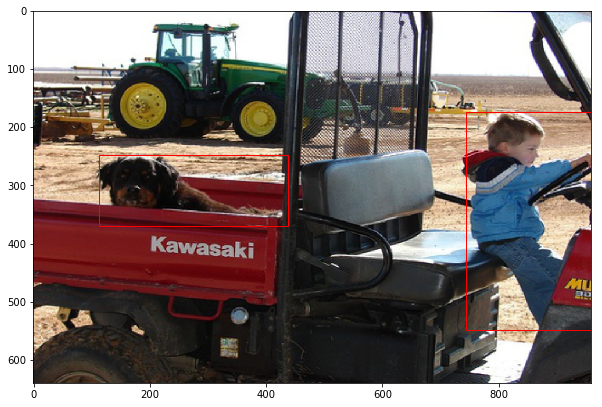

In [3]:
#This jupyter version only used on conv5-3, here I am not use multi-sclae features from different convolutional layer
import batch_generate
i_line = np.random.randint(len(data))
name_str, img, bb_boxes = batch_generate.get_img_by_name(data, i_line, size = (960, 640))
copy_img = img
print(bb_boxes)
gta = batch_generate.bbox_transform(bb_boxes)
print(gta)
plt.figure(figsize=(10,10))
plt.imshow(img)
currentAxis = plt.gca()
for i in range(len(gta)):
    currentAxis.add_patch(plt.Rectangle((gta[i,0], gta[i,1]), gta[i,2]-gta[i,0], gta[i,3]-gta[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [4]:
#Inference
import config
from netarch import *
img_channel_mean = [103.939, 116.779, 123.68]
with tf.Graph().as_default():
    mc = config.model_parameters()
    mc.LOAD_PRETRAINED_MODEL = False
    model = ResNet50(mc, '0')
    saver = tf.train.Saver(model.model_params)
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        saver.restore(sess, './tf_detection/model.ckpt-6000')
        img = img.astype(np.float32)
        img[:, :, 0] -= img_channel_mean[0]
        img[:, :, 1] -= img_channel_mean[1]
        img[:, :, 2] -= img_channel_mean[2]
        #img_per_batch = np.expand_dims(img, axis = 0)
        det_probs, det_boxes = sess.run([model.det_probs, model.det_boxes],feed_dict={model.image_input:[img], model.keep_prob: 1.0})

Input tensor shape to rpn: (1, 40, 60, 1024)
Input tensor shape to rpn_cls_score: (1, 40, 60, 512)
Input tensor shape to rpn_bbox_pred: (1, 40, 60, 512)


/home/walter/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
print(det_probs.shape, det_boxes.shape)
box_probs = np.reshape(det_probs[0],[-1,2])[:,1]
box_delta = np.reshape(det_boxes[0],[21600,4])
print(box_probs.shape, box_delta.shape)

(1, 40, 60, 18) (1, 40, 60, 36)
(21600,) (21600, 4)


In [10]:
import utils
anchor_box = mc.ANCHOR_BOX
pred_box_xyxy = utils.bbox_delta_convert_inv(anchor_box, box_delta)
box_nms, probs_nms, keep = utils.non_max_suppression_fast(pred_box_xyxy, box_probs, 7, overlap_thresh=0.3)
#print(len(probs_nms))
print(box_nms)
#keep = utils.nms(box_delta,box_probs,  0.7)
#print(len(keep))

[[ 644   75 1010  561]
 [ 392  104  797  585]
 [ 374 -204  726  311]
 [ 105  324  972  632]
 [-274  239  591  528]
 [-278  406  546  694]
 [ 847  317 1023  622]]


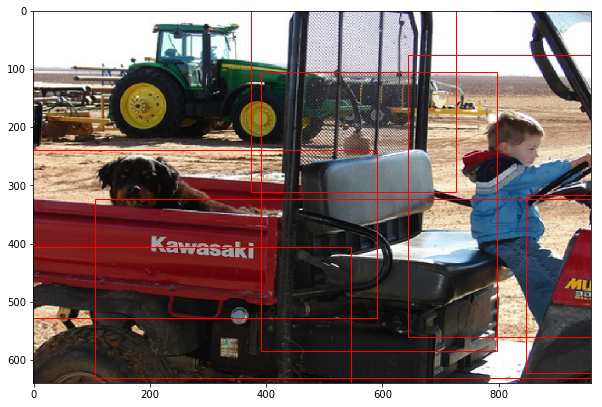

In [11]:
box = box_nms
plt.figure(figsize=(10,10))
plt.imshow(copy_img)
currentAxis = plt.gca()
for i in range(len(box)):
    currentAxis.add_patch(plt.Rectangle((box[i,0], box[i,1]), box[i,2]-box[i,0], box[i,3]-box[i,1], fill=False, edgecolor= 'r', linewidth=1))